In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table
import lightkurve as lk
from matplotlib.collections import LineCollection
from tqdm import tqdm_notebook

import glob, os

from astropy.table import Table
plt.rcParams['font.size'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from scripts import *

In [58]:
targets = Table.read('names_best_cands_4sig_stokesv_clean_leakage_gaia_propermotion_applied stars_added_2019_10_24.fits')
names = targets['common_name']
name = 'CR Dra'
name = names[2].strip()

In [59]:
tics, time, flux, errs, sects, data_all = load_lightcurve(name)

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/lightkurve-2.0.1.dev0-py3.7.egg/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


In [70]:
search = lk.search_lightcurvefile(name)

In [88]:
search = search[np.where(search.target_name==search.target_name[0])]


In [60]:
period = get_rotation_period(tics,time,flux,errs)
print(period)

Finding most likely periods: 100%|██████████| 4/4 [00:00<00:00, 22.81it/s]


1.1579225357122274


In [61]:
avg_preds = run_cnn(tics,time,flux,errs)

Can only use stella.ConvNN.predict().


100%|██████████| 4/4 [00:15<00:00,  3.87s/it]


In [62]:
flare_table = get_flares(tics,time,flux,avg_preds,errs)
flare_table.write('flares_%s.csv' % (name.replace(' ','_').lower()),format='ascii')

Finding & Fitting Flares: 100%|██████████| 4/4 [00:00<00:00,  8.93it/s]


In [63]:
flare_rate = get_flare_rate(time,flare_table)
print(flare_rate)

0.14679856078737485 1 / d


In [67]:
sectors

[24, 24, 25, 25]

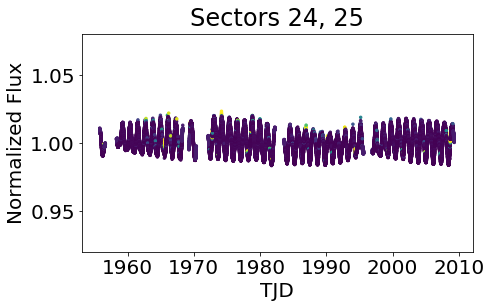

In [83]:
groups,sectors = group_sectors(data_all)
ngroups = len(groups)
width_ratios = [len(group) for group in groups] 
fig, axes = plt.subplots(ncols=ngroups, figsize=(ngroups*7,4),
                           sharey=True, gridspec_kw={'width_ratios':width_ratios})
for j, g in enumerate(groups):
    if len(groups)>1:
        ax = axes[j]
    else:
        ax = axes
    if j == 0:
        ax.set_ylabel('Normalized Flux')
    for i in g:
        ax.scatter(time[i], flux[i], c=avg_preds[i],
                    vmin=0, vmax=1, s=6)
    if len(g)==1:
        ax.set_title('Sector '+str(sectors[g[0]]),y=1.01)
    else:
        ss = [sectors[s] for s in g]
        ax.set_title('Sectors ' + ", ".join([str(s) for s in ss]),y=1.01)
    ax.set_xlabel('TJD')
yrange = np.percentile(np.hstack(flux),(2,50,98))
lims = (yrange[1]-1.0*(yrange[2]-yrange[0]), yrange[1]+1.0*(yrange[2]-yrange[0]))
plt.ylim(*lims)
plt.subplots_adjust(wspace=0.1)


TypeError: 'AxesSubplot' object is not subscriptable

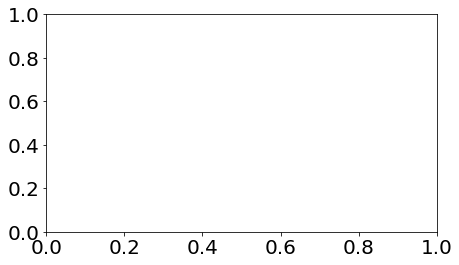

In [64]:
do_plots(tics,time,flux,avg_preds,errs,data_all)
plt.savefig('flare_lc_%s.png' % (name.replace(' ','_').lower()),bbox_inches='tight')

In [54]:
f = open('%s_output.txt' % (name.replace(' ','_').lower()),'w')
f.write('%s\n%f\n%f\n' % (name,period,flare_rate.value))
f.close()

In [55]:
for j in range(len(names)):
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [104]:
savedir = 'results/'

saved_files = glob.glob(savedir+'*')


In [105]:
saved_files

['results/flare_lc_2mass_j09481615+5114518.png',
 'results/flares_ou_and.csv',
 'results/flare_lc_gj_1151.png',
 'results/flare_lc_yy_gem.png',
 'results/lp_169-22_output.txt',
 'results/flare_lc_lp_212-62.png',
 'results/flares_gj_3861.csv',
 'results/flares_gj_450.csv',
 'results/gj_3789_output.txt',
 'results/fg_uma_output.txt',
 'results/flares_lp_212-62.csv',
 'results/bd+33_4462_output.txt',
 'results/g_240-45_output.txt',
 'results/flare_lc_ww_dra.png',
 'results/flare_lc_bd+33_4462.png',
 'results/flares_gj_9552.csv',
 'results/flares_fk_com.csv',
 'results/yy_gem_output.txt',
 'results/bf_lyn_output.txt',
 'results/flare_lc_2mass_j14333139+3417472.png',
 'results/bq_cvn_output.txt',
 'results/flare_lc_bh_cvn.png',
 'results/flare_lc_dm_uma.png',
 'results/flare_lc_gj_3861.png',
 'results/flares_fg_uma.csv',
 'results/flare_lc_ev_dra.png',
 'results/2mass_j09481615+5114518_output.txt',
 'results/flare_lc_gj_412.png',
 'results/flares_bq_cvn.csv',
 'results/flare_lc_gj_9552.png'

In [87]:
'%s%s_output.txt' % (savedir,name.replace(' ','_').lower()) in saved_files

False

Failed on: 
44i Boo BD+42 2437 2MASS J13272299+4136071 GJ 3729 2MASS J10534129+5253040 2MASS J10241364+3902333 PSR J1012+5307 FI Cnc EZ Peg PSR J1012+5307 AD Leo TYC 2834-1385-1 FG Gam II Peg DO Cep